# A Generative Modelling Approach to Image translation
Written by [Samuel Tonks](https://github.com/Tonks684), Krull Lab University of Birmingham UK, with many inputs and bugfixes from [Eduardo Hirata-Miyasaki](https://github.com/edyoshikun), [Ziwen Liu](https://github.com/ziw-liu) and [Shalin Mehta](https://github.com/mattersoflight) of CZ Biohub San Francisco.

## Overview

In part 2 of the image_translation exercise, we will predict fluorescence images of nuclei markers only from quantitative phase images of cells, using a specific type of generative model called a Conditional Generative Adversarial Network (cGAN). In contrast to a regression-based approach, cGANs learn to map from the phase contrast domain to a distirbution of virtual staining solutions. In this work we will utilise the [Pix2PixHD GAN](https://arxiv.org/abs/1711.11585) used in our recent [virtual staining works](https://ieeexplore.ieee.org/abstract/document/10230501?casa_token=NEyrUDqvFfIAAAAA:tklGisf9BEKWVjoZ6pgryKvLbF6JyurOu5Jrgoia1QQLpAMdCSlP9gMa02f3w37PvVjdiWCvFhA). For more details on the architecture and loss components of cGANs and Pix2PixHD GAN please see the READ.me. 

During this exercise will assess the different loss components of a pre-trained Pix2PixHD for the virtual nuclei staining task. We will then evaluate the performance of the model on unseen data using the same pixel-level and instance-level metrics as in the previous section. We will compare the performance of the Pix2PixHD GAN with the regression-based model Viscy. Finally, as a bonus, we will explore the variability and uncertainty in the virtual stain predictions using [MC-Dropout](https://arxiv.org/abs/1506.02142).

## References
- [Wang, T. et al. (2018) High-resolution image synthesis and semantic manipulation with conditional GANs](https://arxiv.org/abs/1711.11585)
- [Tonks, S. et al. (2023) Evaluating virtual staining for high-throughput screening](https://ieeexplore.ieee.org/abstract/document/10230501?casa_token=NEyrUDqvFfIAAAAA:tklGisf9BEKWVjoZ6pgryKvLbF6JyurOu5Jrgoia1QQLpAMdCSlP9gMa02f3w37PvVjdiWCvFhA)
- [Gal, Y. et al. (2016) Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142)

## Goals

This part of the exercise is organized in 5 parts.<br>

As you have already explored the data in the previous parts, we will focus on training and evaluating Pix2PixHD GAN. The parts are as follows:<br>

* **Part 1** - Define dataloaders & walk through steps to train a Pix2PixHD GAN.<br>
* **Part 2** - Load and assess a pre-trained Pix2PixGAN using tensorboard, discuss the different loss components and how new hyper-parameter configurations could impact performance.<br>
* **Part 3** - Evaluate performance of pre-trained Pix2PixGAN using pixel-level and instance-level metrics.<br>
* **Part 4** - Compare the performance of Viscy (regression-based) with Pix2PixHD GAN (generative modelling approach)<br>
* **Part 5** - *BONUS*: Sample different virtual staining solutions from the Pix2PixHD GAN using [MC-Dropout](https://arxiv.org/abs/1506.02142) and explore the variability and subsequent uncertainty in the virtual stain predictions.<br>

<div class="alert alert-danger">
Set your python kernel to <span style="color:black;">06_image_translation</span>
</div>

# Part 1: Define dataloaders & walk through steps to train a Pix2PixHD GAN.
---------
The focus of this part of the exercise is on understanding a generative modelling approach to image translation, how to train and evaluate a cGAN, and explore some hyperparameters of the cGAN. 

Learning goals:

- Load dataset and configure dataloader.
- Configure Pix2PixHD GAN to train for translating from phase to nuclei.

In [1]:
# TO DO: Change the path to the directory where the data and code is stored is stored.
import os
import sys
parent_dir = "/home/smt29021/data/06_image_translation/part2/GAN_code/GANs_MI2I/"
sys.path.append(parent_dir)


In [2]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import metrics
from tifffile import imread, imsave
import matplotlib.pyplot as plt
from cellpose import models
from typing import List, Tuple
from numpy.typing import ArrayLike
import warnings
warnings.filterwarnings('ignore')

# Import all the necessary hyperparameters and configurations for training.
from pix2pixHD.options.train_options import TrainOptions
from pix2pixHD.options.test_options import TestOptions

# Import Pytorch dataloader and transforms.
from pix2pixHD.data.data_loader_dlmbl import CreateDataLoader

# Import the model architecture.
from pix2pixHD.models import create_model

# Import helper functions for visualization and processing.
from pix2pixHD.util.visualizer import Visualizer
from pix2pixHD.util import util

# Import train script.
from pix2pixHD.train_dlmbl import train as train_model
from pix2pixHD.test_dlmbl import inference as inference_model
from pix2pixHD.test_dlmbl import sampling

# pytorch lightning wrapper for Tensorboard.
from torch.utils.tensorboard import SummaryWriter

# Import the same evaluation metrics as in the previous section.

from torchmetrics.functional import accuracy, dice, jaccard_index
from torchmetrics.detection import MeanAveragePrecision as mean_average_precision

# Initialize the default options and parse the arguments.
opt = TrainOptions().parse()
# Set the seed for reproducibility.
util.set_seed(42)
# Set the experiment folder name.
translation_task = "nuclei"  # or "cyto" depending on your choice of target for virtual stain.
opt.name = "dlmbl_vsnuclei"
# Path to store all the logs.
top_dir = Path(f"~/data/06_image_translation/part2/").expanduser() # TODO: Change this to point to your data directory.
opt.checkpoints_dir = top_dir/"GAN_code/GANs_MI2I/new_training_runs/"
Path(f'{opt.checkpoints_dir}/{opt.name}').mkdir(parents=True, exist_ok=True)
output_image_folder = top_dir/"tiff_files/"
# Initalize the tensorboard writer.
writer = SummaryWriter(log_dir=opt.checkpoints_dir)

## 1.1 Load Dataset & Configure Dataloaders.<br>
Having already downloaded and split our training, validation and test sets we now need to load the data into the model. We will use the Pytorch DataLoader class to load the data in batches. The DataLoader class is an iterator that provides a consistent way to load data in batches. We will also use the CreateDataLoader class to load the data in the correct format for the Pix2PixHD GAN.

In [ ]:
# Initialize the Dataset and Dataloaders.

## Define Dataset & Dataloader options.
opt.dataroot = output_image_folder
opt.data_type = 16  # Data type of the images.
opt.loadSize = 512  # Size of the loaded phase image.
opt.input_nc = 1  # Number of input channels.
opt.output_nc = 1  # Number of output channels.
opt.resize_or_crop = "none"  # Scaling and cropping of images at load time [resize_and_crop|crop|scale_width|scale_width_and_crop|none].
opt.target = "nuclei"  # or "cyto" depending on your choice of target for virtual stain.

# Load Training Set for input into model
opt.isTrain = True 
train_dataloader = CreateDataLoader(opt)
dataset_train = train_dataloader.load_data()
print(f"Total Training Images = {len(train_dataloader)}")

# Load Val Set
opt.phase = "val"
val_dataloader = CreateDataLoader(opt)
dataset_val = val_dataloader.load_data()
print(f"Total Validation Images = {len(val_dataloader)}")
opt.phase= "train"

# Plot a sample image from the training set.

## Configure Pix2PixHD GAN and train to predict nuclei from phase.
Having loaded the data into the model we can now train the Pix2PixHD GAN to predict nuclei from phase. We will use the following hyperparameters to train the model:

In [ ]:
# Define the parameters for the Generator.
opt.ngf = 64  # Number of filters in the generator.
opt.n_downsample_global = 4  # Number of downsampling layers in the generator.
opt.n_blocks_global = 9  # Number of residual blocks in the generator.
opt.n_blocks_local = 3  # Number of residual blocks in the generator.
opt.n_local_enhancers = 1  # Number of local enhancers in the generator.

# Define the parameters for the Discriminators.
opt.num_D = 3  # Number of discriminators.
opt.n_layers_D = 3  # Number of layers in the discriminator.
opt.ndf = 32  # Number of filters in the discriminator.

# Define general training parameters.
opt.gpu_ids = [0] # GPU ids to use.
opt.norm = "instance"  # Normalization layer in the generator.
opt.use_dropout = ""  # Use dropout in the generator (fixed at 0.2).
opt.batchSize = 8  # Batch size.

# Create a visualizer to perform image processing and visualization
visualizer = Visualizer(opt)

# Here will first start training a model from scrach however we can continue to train from a previously trained model by setting the following parameters.
opt.continue_train = False
if opt.continue_train:
    iter_path = os.path.join(opt.checkpoints_dir, opt.name, "iter.txt")
    try:
        start_epoch, epoch_iter = np.loadtxt(iter_path, delimiter=",", dtype=int)
    except:
        start_epoch, epoch_iter = 1, 0
    print("Resuming from epoch %d at iteration %d" % (start_epoch, epoch_iter))
else:
    start_epoch, epoch_iter = 1, 0
    
print('------------ Options -------------')
for k, v in sorted(vars(opt).items()):
    print('%s: %s' % (str(k), str(v)))
print('-------------- End ----------------')

# Set the number of epoch to be 1 for demonstration purposes
opt.n_epochs = 2
# Initialize the model
phase2nuclei_model = create_model(opt)
# Define Optimizers for G and D
optimizer_G, optimizer_D = (
    phase2nuclei_model.module.optimizer_G,
    phase2nuclei_model.module.optimizer_D,
)

In [ ]:
train_model(
    opt,
    phase2nuclei_model,
    visualizer,
    dataset_train,
    dataset_val,
    optimizer_G,
    optimizer_D,
    start_epoch,
    epoch_iter,
    writer,
)

<div class="alert alert-info">

## A heads up of what to expect from the training...
<br><br>
**- Visualise results**: We can observe how the performance improves over time using the images tab and the sliding window.
<br><br>
**- Discriminator Predicted Probabilities**: We plot the discriminator's predicted probabilities that the phase with fluorescence is phase and fluorescence and that the phase with virtual stain is phase with virtual stain. It is typically trained until the discriminator can no longer classify whether or not the generated images are real or fake better than a random guess (p(0.5)). We plot this for both the training and validation datasets.
<br><br>
**- Adversarial Loss**: We can formulate the adversarial loss as a Least Squared Error Loss in which for real data the discriminator should output a value close to 1 and for fake data a value close to 0. The generator's goal is to make the discriminator output a value as close to 1 for fake data. We plot the least squared error loss.
<br><br>
**- Feature Matching Loss**: Both networks are also trained using the generator feature matching loss which encourages the generator to produce images that contain similar statistics to the real images at each scale. We also plot the feature matching L1 loss for the training and validation sets together to observe the performance and how the model is fitting the data.
<br><br>
This implementation allows for the turning on/off of the least-square loss term by setting the opt.no_lsgan flag to the model options. As well as the turning off of the feature matching loss term by setting the opt.no_ganFeat_loss flag to the model options. Something you might want to explore in the next section!<br><br>
</div>

<div class="alert alert-success">
    
## Checkpoint 1

Congratulations! You should now have a better understanding of how to train a Pix2PixHD GAN model for translating from phase to nuclei. You should also have a good understanding of the different loss components of Pix2PixHD GAN and how they are used to train the model.

</div>

# Part 2: Load & Assess trained Pix2PixGAN using tensorboard, discuss performance of the model.
--------------------------------------------------
Learning goals:
- Load a pre-trained Pix2PixHD GAN model for either phase to nuclei.
- Discuss the loss components of Pix2PixHD GAN and how they are used to train the model.
- Evaluate the fit of the model on the train and validation datasets.

In this part, we will evaluate the performance of the pre-trained model. We will begin by looking qualitatively at the model predictions, then dive into the different loss plots. We will discuss the implications of different hyper-parameter combinations for the performance of the model.

In [ ]:
log_dir = f"{top_dir}/model_tensorboard/{opt.name}/"
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir $log_dir

<div class="alert alert-info">

## Training Results
Please note down your thoughts about the following questions...
<br><br>
**- What do you notice about the virtual staining predictions? How do they appear compared to the regression-based approach? Can you spot any hallucinations?**<br><br> 
**- What do you notice about the probabilities of the discriminators? How do the values compare during training compared to validation?**<br><br>
**- What do you notice about the feature matching L1 loss?**<br><br>
**- What do you notice about the least-square loss?**<br><br>
</div>

<div class="alert alert-success">
    
## Checkpoint 2
Congratulations! You should now have a better understanding the different loss components of Pix2PixHD GAN and how they are used to train the model. You should also have a good understanding of the fit of the model during training on the training and validation datasets.

</div>

# Part 3: Evaluate performance of the virtual staining on unseen data.
--------------------------------------------------
## Evaluate the performance of the model.
We now look at the same metrics of performance of the previous model. We typically evaluate the model performance on a held out test data. 

Steps:
- Define our model parameters for the pre-trained model (these are the same parameters as shown in earlier cells but copied here for clarity).
- Load the test data.

We will first load the test data using the same format as the training and validation data. We will then use the model to sample a virtual nuclei staining soltuion from the phase image. We will then evaluate the performance of the model using the following metrics:

Pixel-level metrics:
- [Peak-Signal-to-Noise-Ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio).
- [Structural Similarity Index Measure (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity).
- [Pearson Correlation Coefficient (PCC)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

Instance-level metrics via [Cellpose masks](https://cellpose.org/):
- [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)
- [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index)
- [Dice Score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
- [Mean Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision)

In [3]:
opt = TestOptions().parse(save=False)

# Define the parameters for the dataset.
opt.dataroot = output_image_folder
opt.data_type = 16  # Data type of the images.
opt.loadSize = 512  # Size of the loaded phase image.
opt.input_nc = 1  # Number of input channels.
opt.output_nc = 1  # Number of output channels.
opt.target = "nuclei"  # "nuclei" or "cyto" depending on your choice of target for virtual stain.
opt.resize_or_crop = "none"  # Scaling and cropping of images at load time [resize_and_crop|crop|scale_width|scale_width_and_crop|none].
opt.batchSize = 1 # Batch size for training

# Define the model parameters for the pre-trained model.

# Define the parameters for the Generator.
opt.ngf = 64  # Number of filters in the generator.
opt.n_downsample_global = 4  # Number of downsampling layers in the generator.
opt.n_blocks_global = 9  # Number of residual blocks in the generator.
opt.n_blocks_local = 3  # Number of residual blocks in the generator.
opt.n_local_enhancers = 1  # Number of local enhancers in the generator.

# Define the parameters for the Discriminators.
opt.num_D = 3  # Number of discriminators.
opt.n_layers_D = 3  # Number of layers in the discriminator.
opt.ndf = 32  # Number of filters in the discriminator.

# Define general training parameters.
opt.gpu_ids= [0]  # GPU ids to use.
opt.norm = "instance"  # Normalization layer in the generator.
opt.use_dropout = ""  # Use dropout in the generator (fixed at 0.2).
opt.batchSize = 8  # Batch size.

# Define loss functions.
opt.no_vgg_loss = ""  # Turn off VGG loss
opt.no_ganFeat_loss = ""  # Turn off feature matching loss
opt.no_lsgan = ""  # Turn off least square loss

# Additional Inference parameters
opt.name = f"dlmbl_vsnuclei"
opt.how_many = 112  # Number of images to generate.
opt.checkpoints_dir = f"{top_dir}/model_weights/"  # Path to the model checkpoints.
opt.results_dir = f"{top_dir}/GAN_code/GANs_MI2I/pre_trained/{opt.name}/inference_results/"  # Path to store the results.
opt.which_epoch = "latest"  # or specify the epoch number "40"
opt.phase = "test"

opt.nThreads = 1  # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
Path(opt.results_dir).mkdir(parents=True, exist_ok=True)

# Load the test data.
test_data_loader = CreateDataLoader(opt)
test_dataset = test_data_loader.load_data()
visualizer = Visualizer(opt)
print(f"Total Test Images = {len(test_data_loader)}")
# Load pre-trained model
model = create_model(opt)

HEKCells Data Loader
dataset [HEKCells Dataset] was created
Total Test Images = 112
GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=

In [4]:
# Generate & save predictions in the results directory.
inference_model(test_dataset, opt, model)

100%|█████████████████████████████████████████| 112/112 [00:08<00:00, 13.84it/s]


In [5]:
# Gather results for evaluation
virtual_stain_paths = sorted([i for i in Path(opt.results_dir).glob("**/*.tiff")])
target_stain_paths = sorted([i for i in Path(f"{output_image_folder}/{translation_task}/test/").glob("**/*.tiff")])
phase_paths = sorted([i for i in Path(f"{output_image_folder}/input/test/").glob("**/*.tiff")])
assert (len(virtual_stain_paths) == len(target_stain_paths) == len(phase_paths)
), f"Number of images do not match. {len(virtual_stain_paths)},{len(target_stain_paths)} {len(phase_paths)} "

# Create arrays to store the images.
virtual_stains = np.zeros((len(virtual_stain_paths), 512, 512))
target_stains = virtual_stains.copy()
phase_images = virtual_stains.copy()
# Load the images and store them in the arrays.
for index, (v_path, t_path, p_path) in tqdm(
    enumerate(zip(virtual_stain_paths, target_stain_paths, phase_paths))
):
    virtual_stain = imread(v_path)
    phase_image = imread(p_path)
    target_stain = imread(t_path)
    # Append the images to the arrays.
    phase_images[index] = phase_image
    target_stains[index] = target_stain
    virtual_stains[index] = virtual_stain

112it [00:00, 255.38it/s]


<div class="alert alert-info">

### Task 3.1 Visualise the results of the model on the test set.

Create a matplotlib plot that visalises random samples of the phase images, target stains, and virtual stains.
If you can incorporate the crop function below to zoom in on the images that would be great!
</div>

In [6]:
# Define a function to crop the images so we can zoom in.
def crop(img, crop_size, loc='center'):
    """
    Crop the input image.

    Parameters:
    img (ndarray): The image to be cropped.
    crop_size (int): The size of the crop.
    loc (str): The type of crop to perform. Can be 'center' or 'random'.

    Returns:
    ndarray: The cropped image array.
    """
    # Dimension of input array
    width, height = img.shape

    # Generate random coordinates for the crop
    max_y = height - crop_size
    max_x = max_y

    if loc == 'random':
        start_y = np.random.randint(0, max_y + 1)
        start_x = np.random.randint(0, max_x + 1)
        end_y = start_y + crop_size
        end_x = start_x + crop_size
    elif loc == 'center':
        start_x = (width - crop_size) // 2
        start_y = (height - crop_size) // 2
        end_y = height - start_y
        end_x = width - start_x
    else:
        raise ValueError(f'Unknown crop type {loc}')

    # Crop array using slicing
    crop_array = img[start_x:end_x, start_y:end_y]
    return crop_array

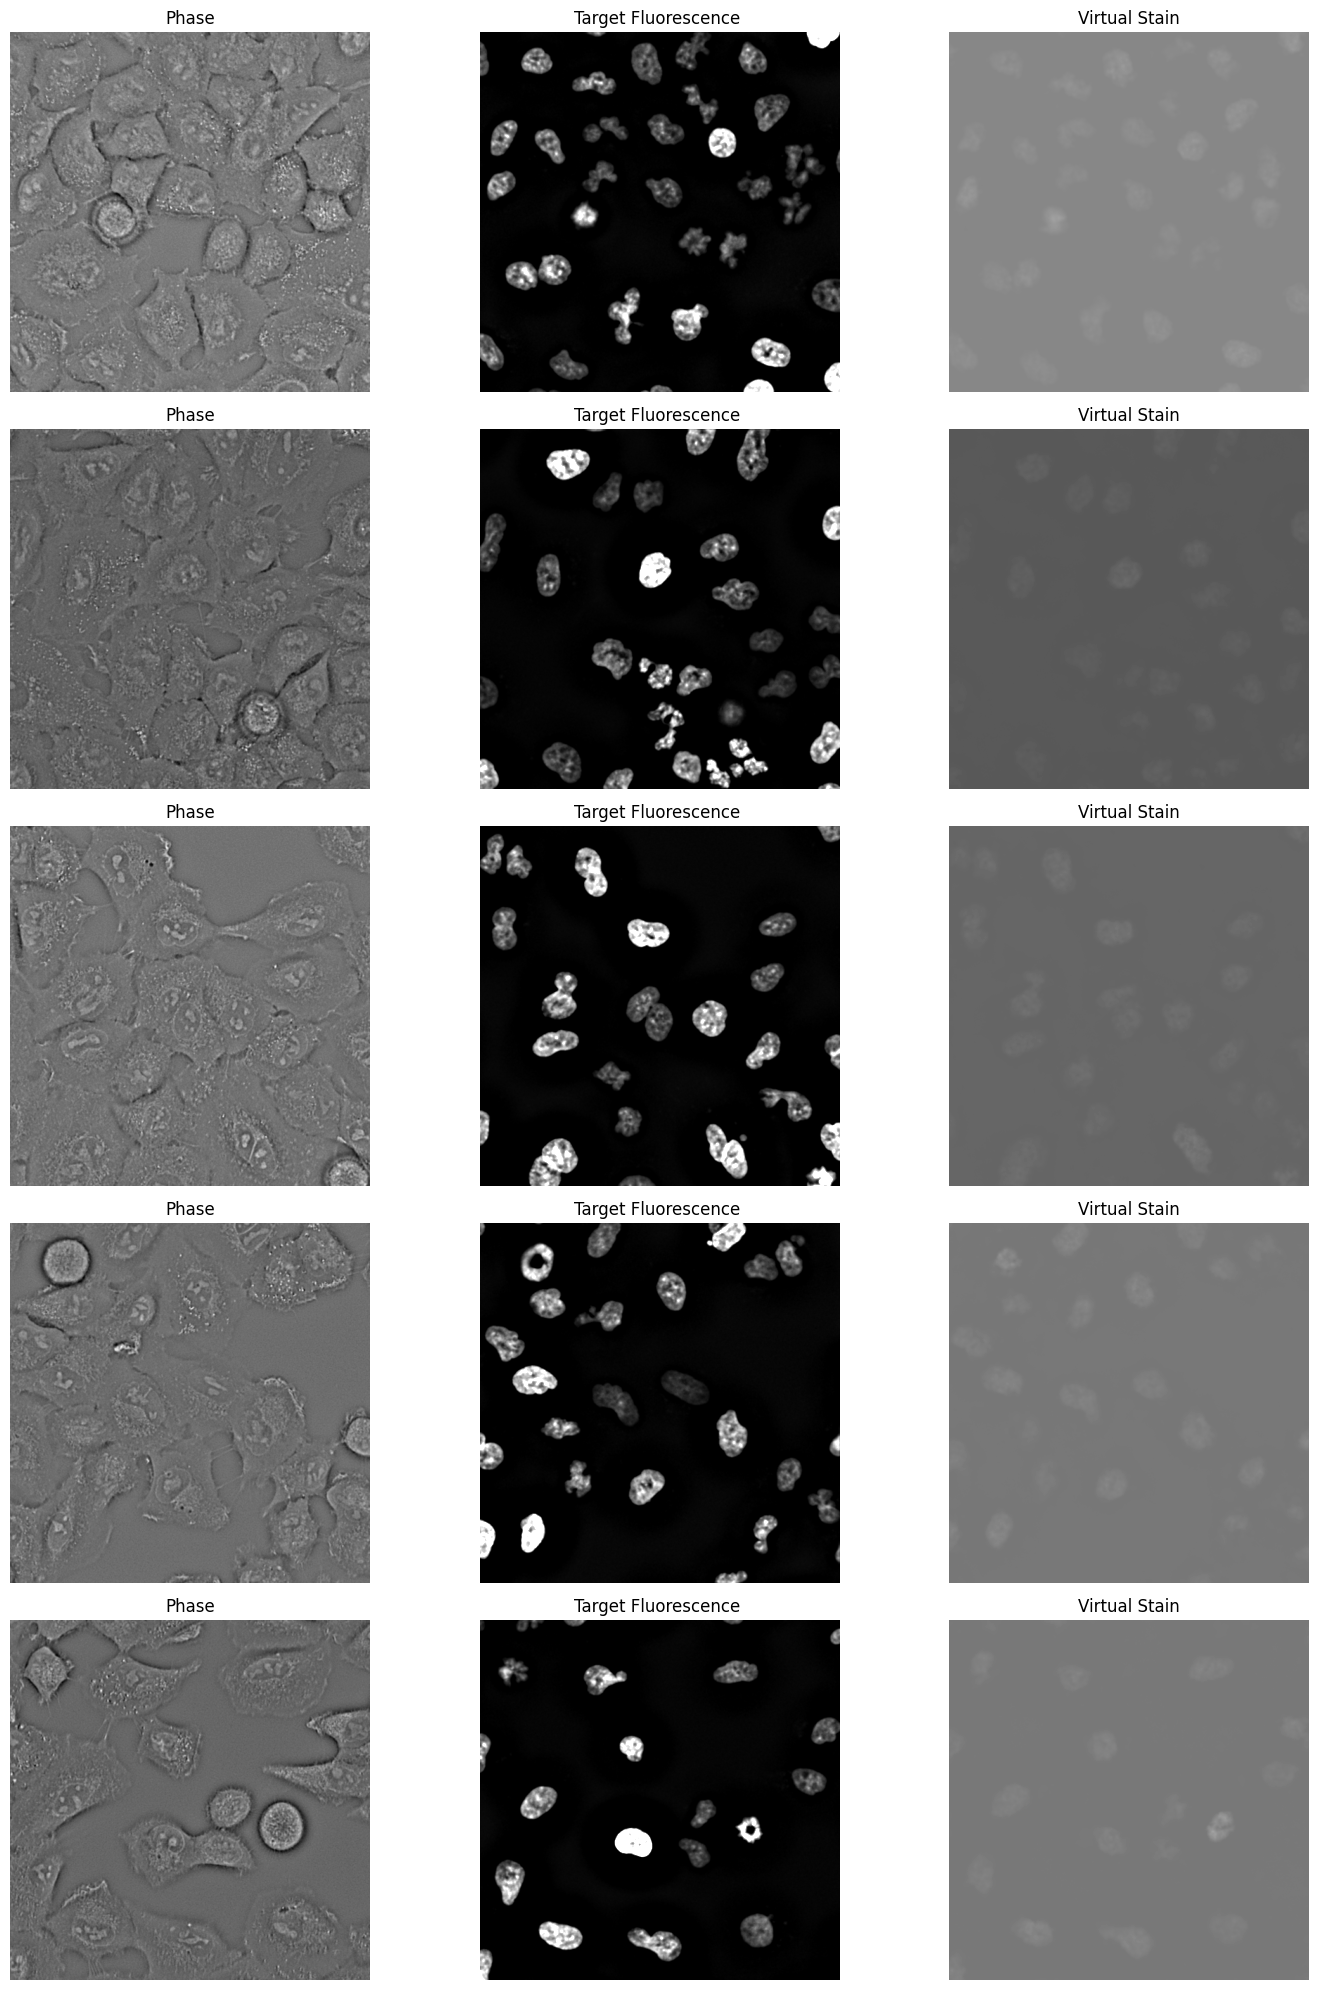

In [7]:

##########################
######## Solution ########
##########################

def visualise_results(phase_images, target_stains, virtual_stains, crop_size=None, loc='center'):
    """
    Visualizes the results of image processing by displaying the phase images, target stains, and virtual stains.
    Parameters:
    - phase_images (np.array): Array of phase images.
    - target_stains (np.array): Array of target stains.
    - virtual_stains (np.array): Array of virtual stains.
    - crop_size (int, optional): Size of the crop. Defaults to None.
    - type (str, optional): Type of crop. Defaults to 'center' but can be 'random.
    Returns:
    None
    """  
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    sample_indices = np.random.choice(len(phase_images), 5)
    for index,sample in enumerate(sample_indices):
        if crop_size:
            phase_image = crop(phase_images[index], crop_size, loc)
            target_stain = crop(target_stains[index], crop_size, loc)
            virtual_stain = crop(virtual_stains[index], crop_size, loc)
        else:
            phase_image = phase_images[index]
            target_stain = target_stains[index]
            virtual_stain = virtual_stains[index]  

        axes[index, 0].imshow(phase_image, cmap="gray")
        axes[index, 0].set_title("Phase")
        axes[index, 1].imshow(
            target_stain,
            cmap="gray",
            vmin=np.percentile(target_stain, 1),
            vmax=np.percentile(target_stain, 99),
        )
        axes[index, 1].set_title("Target Fluorescence ")
        axes[index, 2].imshow(
            virtual_stain,
            cmap="gray",
            vmin=np.percentile(target_stain, 1),
            vmax=np.percentile(target_stain, 99),
        )
        axes[index, 2].set_title("Virtual Stain")
    for ax in axes.flatten():
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualise_results(phase_images, target_stains,virtual_stains,crop_size=None)

<div class="alert alert-info">

### Task 3.2 Compute pixel-level metrics

Compute the pixel-level metrics for the virtual stains and target stains.

The following code will compute the following:
- the pixel-based metrics  (Pearson correlation, SSIM, PSNR) for the virtual stains and target stains.

</div>

112it [00:03, 32.28it/s]


<Axes: >

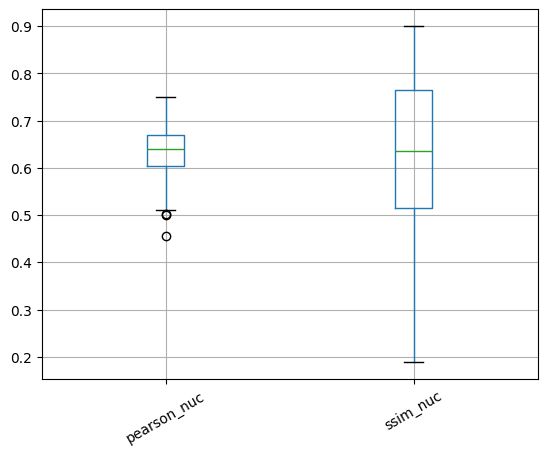

In [8]:

# Define the function to perform  minmax normalization which is required for the pixel-level metrics.
def min_max_scale(input):
    return (input - np.min(input)) / (np.max(input) - np.min(input))

# Create a dataframe to store the pixel-level metrics.
test_pixel_metrics = pd.DataFrame(
    columns=["model", "fov","pearson_nuc", "ssim_nuc", "psnr_nuc"]
)

# Compute the pixel-level metrics.
for i, (target_stain, predicted_stain) in tqdm(enumerate(zip(target_stains, virtual_stains))):
    fov = str(virtual_stain_paths[i]).split("/")[-1].split(".")[0]
    minmax_norm_target = min_max_scale(target_stain)
    minmax_norm_predicted = min_max_scale(predicted_stain)
    
    # Compute SSIM
    ssim_nuc = metrics.structural_similarity(
        minmax_norm_target, minmax_norm_predicted, data_range=1
    )
    # Compute Pearson correlation
    pearson_nuc = np.corrcoef(
        minmax_norm_target.flatten(), minmax_norm_predicted.flatten()
        )[0, 1]
    # Compute PSNR
    psnr_nuc = metrics.peak_signal_noise_ratio(
        minmax_norm_target, minmax_norm_predicted, data_range=1
    )
    
    test_pixel_metrics.loc[len(test_pixel_metrics)] = {
            "model": "pix2pixHD",
            "fov":fov,
            "pearson_nuc": pearson_nuc,
            "ssim_nuc": ssim_nuc,
            "psnr_nuc": psnr_nuc, 
        }
    
test_pixel_metrics.boxplot(
    column=["pearson_nuc", "ssim_nuc"],
    rot=30,
)

<Axes: >

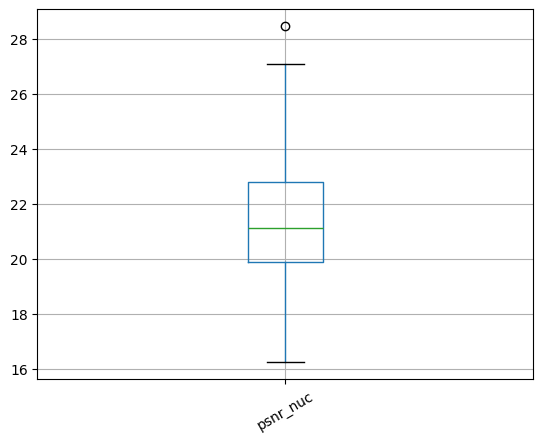

In [9]:
test_pixel_metrics.boxplot(
    column=["psnr_nuc"],
    rot=30,
)

In [10]:
test_pixel_metrics.head()

,model,fov,pearson_nuc,ssim_nuc,psnr_nuc
0,pix2pixHD,0_0_crop0,0.632699,0.780111,21.647637
1,pix2pixHD,0_0_crop1,0.618226,0.777401,22.236295
2,pix2pixHD,0_0_crop10,0.742866,0.381269,19.968186
3,pix2pixHD,0_0_crop11,0.660743,0.697657,22.010801
4,pix2pixHD,0_0_crop12,0.595256,0.878488,26.541245


- What do these metrics tells us about the performance of the model?
- How do the pixel-level metrics compare to the regression-based approach?
- Could these metrics be skewed by the presence of hallucinations or background pilxels in the virtual stains?

<div class="alert alert-info">

### Task 3.3 Compute instance-level metrics

- Compute the instance-level metrics for the virtual stains and target stains.
- Instance metrics include the accuracy (average correct predictions with 0.5 threshold), jaccard index (intersection over union (IoU)) dice score (2x intersection over union), mean average precision, mean average precision at 50% IoU, mean average precision at 75% IoU, and mean average recall at 100% IoU.


</div>

In [11]:

# Use the same function as previous part to extract the nuclei masks from pre-trained cellpose model.
def cellpose_segmentation(prediction:ArrayLike,target:ArrayLike)->Tuple[torch.ShortTensor]:
    # NOTE these are hardcoded for this notebook and A549 dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cp_nuc_kwargs = {
        "diameter": 65,
#         "channels": [0], 
        "cellprob_threshold": 0.0, 
    }
    cellpose_model = models.CellposeModel(
            gpu=True, model_type='nuclei', device=torch.device(device)
    )
    pred_label, _, _ = cellpose_model.eval(prediction, **cp_nuc_kwargs)
    target_label, _, _ = cellpose_model.eval(target, **cp_nuc_kwargs)

    pred_label = pred_label.astype(np.int32)
    target_label = target_label.astype(np.int32)
    pred_label = torch.ShortTensor(pred_label)
    target_label = torch.ShortTensor(target_label)

    return (pred_label,target_label)

# Define dataframe to store the segmentation metrics.
test_segmentation_metrics= pd.DataFrame(
    columns=["model", "fov","masks_per_fov","accuracy","dice","jaccard","mAP","mAP_50","mAP_75","mAR_100"]
)
# Define tuple to store the segmentation results. Each value in the tuple is a dictionary containing the model name, fov, predicted label, predicted stain, target label, and target stain.
segmentation_results = ()

for i, (target_stain, predicted_stain) in tqdm(enumerate(zip(target_stains, virtual_stains))):
    fov = str(virtual_stain_paths[i]).split("/")[-1].split(".")[0]
    minmax_norm_target = min_max_scale(target_stain)
    minmax_norm_predicted = min_max_scale(predicted_stain)
    # Compute the segmentation masks.
    pred_label, target_label = cellpose_segmentation(minmax_norm_predicted, minmax_norm_target)
     # Binary labels
    pred_label_binary = pred_label > 0
    target_label_binary = target_label > 0

    # Use Coco metrics to get mean average precision
    coco_metrics = mean_average_precision(pred_label, target_label)
    # Find unique number of labels
    num_masks_fov = len(np.unique(pred_label))
    # Find unique number of labels
    num_masks_fov = len(np.unique(pred_label))
    # Compute the segmentation metrics.
    test_segmentation_metrics.loc[len(test_segmentation_metrics)] = {
        "model": "pix2pixHD",
        "fov":fov,
        "masks_per_fov": num_masks_fov,
        "accuracy": accuracy(pred_label_binary, target_label_binary, task="binary").item(),
        "dice":  dice(pred_label_binary, target_label_binary).item(),
        "jaccard": jaccard_index(pred_label_binary, target_label_binary, task="binary").item(),
        "mAP":coco_metrics["map"].item(),
        "mAP_50":coco_metrics["map_50"].item(),
        "mAP_75":coco_metrics["map_75"].item(),
        "mAR_100":coco_metrics["mar_100"].item()
        }
    # Store the segmentation results.
    segmentation_result = {
        "model": "pix2pixHD",
        "fov":fov,
        "phase_image": phase_images[i],
        "pred_label": pred_label,
        "pred_stain": predicted_stain,
        "target_label": target_label,
        "target_stain": target_stain,
    }
    segmentation_results += (segmentation_result,)

test_segmentation_metrics.head()

0it [00:02, ?it/s]


ModuleNotFoundError: `MAP` metric requires that `pycocotools` or `faster-coco-eval` installed. Please install with `pip install pycocotools` or `pip install faster-coco-eval` or `pip install torchmetrics[detection]`.

In [ ]:
# Define function to visualize the segmentation results.
def visualise_results_and_masks(segmentation_results: Tuple[dict], rows: int = 5, crop_size: int = None, crop_type: str = 'center'):

    # Sample a subset of the segmentation results.
    sample_indices = np.random.choice(len(phase_images),rows)
    segmentation_results_subset = segmentation_results[sample_indices]
    segmentation_metrics_subset = test_segmentation_metrics.iloc[sample_indices]
    # Define the figure and axes.
    fig, axes = plt.subplots(rows, 5, figsize=(rows*3, 15))

    # Visualize the segmentation results.
    for i, idx in enumerate(segmentation_results_subset):
        result = segmentation_results[idx]
        segmentation_metrics = segmentation_metrics_subset.iloc[i]
        phase_image = result["phase_image"]
        target_stain = result["target_stain"]
        target_label = result["target_label"]
        pred_stain = result["pred_stain"]
        pred_label = result["pred_label"]
        # Crop the images if required. Zoom into instances
        if crop_size is not None:
            phase_image = crop(phase_image, crop_size, crop_type)
            target_stain = crop(target_stain, crop_size, crop_type)
            target_label = crop(target_label, crop_size, crop_type)
            pred_stain = crop(pred_stain, crop_size, crop_type)
            pred_label = crop(pred_label, crop_size, crop_type)
        axes[i, 0].imshow(phase_image, cmap="gray")
        axes[i, 0].set_title("Phase")
        axes[i, 1].imshow(
            target_stain,
            cmap="gray",
            vmin=np.percentile(target_stain, 1),
            vmax=np.percentile(target_stain, 99),
        )
        axes[i, 1].set_title("Target Fluorescence")
        axes[i, 2].imshow(pred_stain, cmap="gray")
        axes[i, 2].set_title("Virtual Stain")
        axes[i, 3].imshow(target_label, cmap="inferno")
        axes[i, 3].set_title("Target Fluorescence Mask")
        axes[i, 4].imshow(pred_label, cmap="inferno")
        # Add Metric values to the title
        axes[i, 4].set_title(f"Virtual Stain Mask\nAcc:{segmentation_metrics['accuracy']:.2f} Dice:{segmentation_metrics['dice']:.2f} Jaccard:{segmentation_metrics['jaccard']:.2f} MAP:{segmentation_metrics['mAP']:.2f}")
    # Turn off the axes.
    for ax in axes.flatten():
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
visualise_results_and_masks(segmentation_results, crop_size=256, crop_type='center')

<div class="alert alert-success">
    
## Checkpoint 3

Congratulations! You have generated predictions from a pre-trained model and evaluated the performance of the model on unseen data. You have computed pixel-level metrics and instance-level metrics to evaluate the performance of the model. You may have also began training your own Pix2PixHD GAN models with alternative hyperparameters.

</div>

# Part 4. Visualise Regression vs Generative Modelling Approaches
--------------------------------------------------

In [ ]:

##########################
######## Solution ########
##########################

def visualise_both_methods(
    phase_images: np.array, target_stains: np.array, pix2pixHD_results: np.array, viscy_results: np.array,crop_size=None,crop_type='center'
):
    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    sample_indices = np.random.choice(len(phase_images), 5)
    if crop_size is not None:
            phase_image = crop(phase_image, crop_size, crop_type)
            target_stain = crop(target_stain, crop_size, crop_type)
            target_label = crop(target_label, crop_size, crop_type)
            pred_stain = crop(pred_stain, crop_size, crop_type)
            pred_label = crop(pred_label, crop_size, crop_type)

    for i, idx in enumerate(sample_indices):
        axes[i, 0].imshow(phase_images[idx], cmap="gray")
        axes[i, 0].set_title("Phase")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(
            target_stains[idx],
            cmap="gray",
            vmin=np.percentile(target_stains[idx], 1),
            vmax=np.percentile(target_stains[idx], 99),
        )
        axes[i, 1].set_title("Nuclei")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(
            viscy_results[idx],
            cmap="gray",
            vmin=np.percentile(target_stains[idx], 1),
            vmax=np.percentile(target_stains[idx], 99),
        )
        axes[i, 2].set_title("Regression\nVirtual Stain")
        axes[i, 2].axis("off")
        
        axes[i, 3].imshow(
            pix2pixHD_results[idx],
            cmap="gray",
            vmin=np.percentile(target_stains[idx], 1),
            vmax=np.percentile(target_stains[idx], 99),
        )
        axes[i, 3].set_title("Pix2PixHD GAN\nVirtual Stain")
        axes[i, 3].axis("off")
    plt.tight_layout()
    plt.show()

# Part 5: BONUS: Sample different virtual staining solutions from the GAN using MC-Dropout and explore the uncertainty in the virtual stain predictions.
--------------------------------------------------
Steps:
- Load the pre-trained model.
- Generate multiple predictions for the same input image.
- Compute the pixel-wise variance across the predictions.
- Visualise the pixel-wise variance to explore the uncertainty in the virtual stain predictions.

In [ ]:
# Use the same model and dataloaders as before.
# Load the test data.
test_data_loader = CreateDataLoader(opt)
test_dataset = test_data_loader.load_data()
visualizer = Visualizer(opt)

# Load pre-trained model
opt.variational_inf_runs = 100 # Number of samples per phase input
opt.variation_inf_path = f"./GAN_code/GANs_MI2I/pre_trained/{opt.name}/samples/"  # Path to store the samples.
opt.dropout_variation_inf = True  # Use dropout during inference.
model = create_model(opt)
# Generate & save predictions in the variation_inf_path directory.
sampling(test_dataset, opt, model)

In [ ]:
# Visualise Samples                                      
samples = sorted([i for i in Path(f"./GAN_code/GANs_MI2I/pre_trained/{opt.name}/samples").glob("**/*mask*.tif*")])
# Create arrays to store the images.
sample_images = np.zeros((len(samples),112, 512, 512)) # (samples, images, height, width)
# Load the images and store them in the arrays.
for index, sample_path in tqdm(enumerate(samples)):
    sample_image = imread(sample_path)
    # Append the images to the arrays.
    sample_images[index] = sample_image
# Plot the phase image, the target image, the variance of samples and 3 samples

# Create a matplotlib plot with animation through images.
import matplotlib.animation as animation

def animate_images(images):
    fig, ax = plt.subplots()
    ax.axis('off')
    im = ax.imshow(images[0], cmap='gray')

    def update(i):
        im.set_array(images[i])
        return im,

    ani = animation.FuncAnimation(fig, update, frames=len(images), interval=200)
    plt.show()

animate_images(sample_images)

# Visualise the results of the model on the test set.
fig, axes = plt.subplots(3, 7, figsize=(20, 5))
sample_indices = np.random.choice(sample_images.shape[1], 3)
for row, indices in enumerate(sample_indices):
    axes[row, 0].imshow(phase_images[indices], cmap="gray")
    axes[row, 0].set_title("Phase")
    axes[row,0].axis("off")
    axes[row, 1].imshow(target_stains[indices], cmap="gray")
    axes[row, 1].set_title("Target Fluorescence")
    axes[row,1].axis("off")
    variance = np.var(sample_images[:,indices], axis=0)
    axes[row, 2].imshow(variance, cmap="inferno")
    axes[row, 2].set_title("Pixel-wise Sample Variance")
    axes[row, 2].axis("off")
    for col in range(3, 7):
        axes[row, col].imshow(sample_images[col-3,indices], cmap="gray")
        axes[row, col].set_title(f"Sample {col-3}")
        axes[row,col].axis("off")
plt.tight_layout()
plt.show()                          
    
                                      